# Handwriten Recognition System
---

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/), a collection of handwritten digit images, has been widely used as a benchmark for image classification tasks in the field of machine learning. 
In this notebook, we will explore the process of training a Multi-Layer Perceptron (MLP), a type of neural network, to classify the images contained in the MNIST database.

We will break down the process into four key steps:

The process will be broken down into the following steps:
>1. Load and visualize the data to get a better understanding of the distribution and characteristics of the images.
2. Define a neural network architecture that can accurately classify the images.
3. Train the model by updating its parameters based on the training data.
4. Evaluate the performance of the trained model on a separate test dataset to measure its accuracy and identify any areas for improvement.

Before we start, we will import the necessary libraries for working with data and PyTorch, as well as a few additional libraries for convenience. With these tools in hand, we are ready to dive into the exciting task of building and training our very own MNIST classifier!

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

In this section, we will load the `MNIST dataset` and specify the transforms we want to apply to it. 

Once we have created the dataset, we will define a DataLoader for both the train and the test set. 
By using a DataLoader, we can shuffle the data, set the batch size, and apply any other necessary transformations in an organized and efficient manner."

In [4]:
def create_datasets(batch_size): 
   
    # Define the data transformations that will be applied to the images
    transform = transforms.Compose([
        # This transforms takes a np.array or a PIL image of integers
        # in the range 0-255 and transforms it to a float tensor in the
        # range 0.0 - 1.0
        transforms.ToTensor(),
        # This then renormalize the tensor to be between -1.0 and 1.0,
        # which is a better range for modern activation functions like
        # Relu 
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    
    # Load the MNIST train and validation dataset
    trainval_data = torchvision.datasets.MNIST(
        root="data", train=True, download=True, transform=transform
    )

    # Split in train and validation
    train_len = int(len(trainval_data) * 0.8)
    val_len = len(trainval_data) - train_len
    train_subset, val_subset = torch.utils.data.random_split(
        trainval_data, [train_len, val_len], generator=torch.Generator().manual_seed(42)
    )

    train_loader = torch.utils.data.DataLoader( dataset=train_subset, shuffle=True, batch_size=batch_size)
    val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size)
    print(f"Using {train_len} examples for training and {val_len} for validation")
    
    # Load the MNIST test dataset
    test_subset = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transform)
    
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size)
    print(f"Using {len(test_subset)} for testing")

    return train_loader, val_loader, test_loader

# Set the batch size for the dataloaders
batch_size = 250

# Create the train and test dataloaders
train_loader, val_loader, test_loader = create_datasets(batch_size)


Using 48000 examples for training and 12000 for validation
Using 10000 for testing


## Explore the Dataset

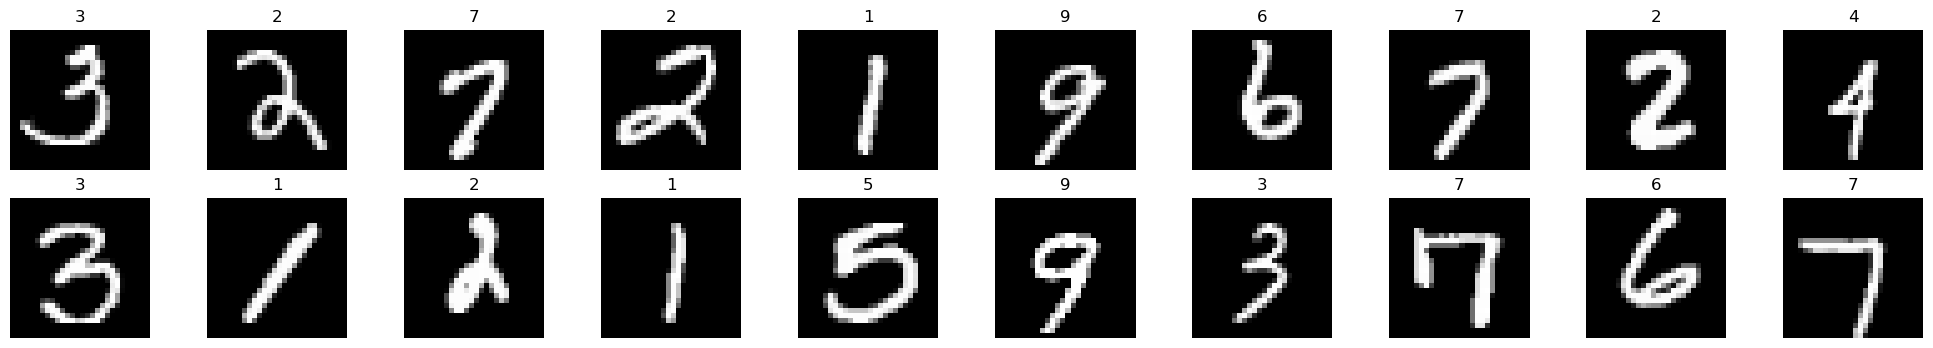

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig, subs = plt.subplots(2, 10, figsize=(25, 4))
for idx, sub in zip(np.arange(20), subs.flatten()):
    sub.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    sub.set_title(str(labels[idx].item()))
    sub.axis("off")